In [1]:
import requests
import re
import json
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import _thread
import time
import jieba
import jieba.analyse
from collections import Counter
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
from queue import Queue
import threading

PTT_URL = 'https://www.ptt.cc/bbs/HatePolitics/index.html'

In [2]:
def multi(urls):
    q_data = Queue()
    q_push = Queue()

    threads = []
    for url in urls:
        t = threading.Thread(target=crawl_article, args=(url, q_data, q_push))
        t.start()
        threads.append(t)

    for t in threads:
        t.join()

    data = []
    push = []

    for i in range(len(threads)):
        data.append((q_data.get()))
        push.extend((q_push.get()))

    return data, push

In [3]:
def crawl_comment_urls(amount=50):
    all_data = []
    comments = []
    nextPage = PTT_URL
    urls = []

    while len(urls) <= amount:
        # 對文章列表送出請求並取得列表主體
        resp = requests.get(nextPage, cookies={'over18': '1'})
        resp.encoding = 'utf-8'

        soup = BeautifulSoup(resp.text, 'html5lib')
        main_list = soup.find('div', class_='bbs-screen')

        nextPage = soup.find('div', 'btn-group btn-group-paging').find_all('a')[1]['href']
        nextPage = 'https://www.ptt.cc' + nextPage

        # 依序檢查文章列表中的 tag, 遇到分隔線就結束, 忽略這之後的文章
        for div in main_list.findChildren('div', recursive=False):

            class_name = div.attrs['class']

            # 遇到分隔線要處理的情況
            if class_name and 'r-list-sep' in class_name:
                print('Reach the last article of this page')
                break
            # 遇到目標文章
            if class_name and 'r-ent' in class_name:
                div_title = div.find('div', class_='title')
                a_title = div_title.find('a', href=True)

                # 如果文章已經被刪除，就跳過
                if not a_title:
                    continue

                article_URL = urljoin(PTT_URL, a_title['href'])
                article_title = a_title.text
                urls.append(article_URL)
                print('Parse {} - {}'.format(article_title, article_URL))

                if len(urls) > amount:
                    print(f'Stop crawling due to reaching the amount. Amount: {len(urls)}')
                    return urls

                # 呼叫上面寫好的 function 來對文章進行爬蟲
                #parse_data, parse_comment = crawl_article(article_URL)
                # parse_data = _thread.start_new_thread(crawl_article, (article_URL, ))

                # 將爬完的資料儲存
                #all_data.append(parse_data)
                #comments.extend(parse_comment)

    return urls

In [4]:
def crawl_article(url, q_data, q_push):
    response = requests.get(url, cookies={'over18': '1'})
    response.encoding = 'utf-8'

    # 假設網頁回應不是 200 OK 的話, 我們視為傳送請求失敗
    if response.status_code != 200:
        print('Error - {} is not available to access'.format(url))
        return

    # 將網頁回應的 HTML 傳入 BeautifulSoup 解析器, 方便我們根據標籤 (tag) 資訊去過濾尋找
    soup = BeautifulSoup(response.text, 'html5lib')

    # 取得文章內容主體
    main_content = soup.find(id='main-content')

    # 假如文章有屬性資料 (meta), 我們在從屬性的區塊中爬出作者 (author), 文章標題 (title), 發文日期 (date)
    metas = main_content.select('div.article-metaline')
    author = ''
    title = ''
    date = ''
    author_id = ''
    author_name = ''
    if metas:
        if metas[0].select('span.article-meta-value')[0]:
            author = metas[0].select('span.article-meta-value')[0].string
            author_separate = author.split(' ')
            author_id = author_separate[0].strip()

            if len(author_separate) > 1:
                author_name = author_separate[1].strip()[1:-1]

        if metas[1].select('span.article-meta-value')[0]:
            title = metas[1].select('span.article-meta-value')[0].string
        if metas[2].select('span.article-meta-value')[0]:
            date = metas[2].select('span.article-meta-value')[0].string

        # 從 main_content 中移除 meta 資訊（author, title, date 與其他看板資訊）
        #
        # .extract() 方法可以參考官方文件
        #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#extract
        for m in metas:
            m.extract()
        for m in main_content.select('div.article-metaline-right'):
            m.extract()

    # 取得留言區主體
    pushes = main_content.find_all('div', class_='push')
    for p in pushes:
        p.extract()

    # 假如文章中有包含「※ 發信站: 批踢踢實業坊(ptt.cc), 來自: xxx.xxx.xxx.xxx」的樣式
    # 透過 regular expression 取得 IP
    # 因為字串中包含特殊符號跟中文, 這邊建議使用 unicode 的型式 u'...'
    try:
        ip = main_content.find(text=re.compile(u'※ 發信站:'))
        ip = re.search('[0-9]*\.[0-9]*\.[0-9]*\.[0-9]*', ip).group()
    except Exception as e:
        ip = ''

    # 移除文章主體中 '※ 發信站:', '◆ From:', 空行及多餘空白 (※ = u'\u203b', ◆ = u'\u25c6')
    # 保留英數字, 中文及中文標點, 網址, 部分特殊符號
    #
    # 透過 .stripped_strings 的方式可以快速移除多餘空白並取出文字, 可參考官方文件
    #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#strings-and-stripped-strings
    filtered = []
    for v in main_content.stripped_strings:
        # 假如字串開頭不是特殊符號或是以 '--' 開頭的, 我們都保留其文字
        if v[0] not in [u'※', u'◆'] and v[:2] not in [u'--']:
            filtered.append(v)

    # 定義一些特殊符號與全形符號的過濾器
    expr = re.compile(u'[^一-龥。；，：“”（）、？《》\s\w:/-_.?~%()]')
    for i in range(len(filtered)):
        filtered[i] = re.sub(expr, '', filtered[i])

    # 移除空白字串, 組合過濾後的文字即為文章本文 (content)
    filtered = [i for i in filtered if i]
    content = ' '.join(filtered)

    # 處理留言區
    # p 計算推文數量
    # b 計算噓文數量
    # n 計算箭頭數量
    p, b, n = 0, 0, 0
    messages = []
    for push in pushes:
        # 假如留言段落沒有 push-tag 就跳過
        if not push.find('span', 'push-tag'):
            continue

        # 過濾額外空白與換行符號
        # push_tag 判斷是推文, 箭頭還是噓文
        # push_userid 判斷留言的人是誰
        # push_content 判斷留言內容
        # push_ipdatetime 判斷留言日期時間
        push_tag = push.find('span', 'push-tag').string.strip(' \t\n\r')
        push_userid = push.find('span', 'push-userid').string.strip(' \t\n\r')
        push_content = push.find('span', 'push-content').strings
        push_content = ' '.join(push_content)[1:].strip(' \t\n\r')
        push_ipdatetime = push.find('span', 'push-ipdatetime').string.strip(' \t\n\r')

        # 整理打包留言的資訊, 並統計推噓文數量
        messages.append({
            'push_tag': push_tag,
            'push_userid': push_userid,
            'push_content': push_content,
            'push_ipdatetime': push_ipdatetime,
            'push_ipdate': push_ipdatetime.split(' ')[0].strip()
        })

        # comments.append(messages)
        if push_tag == u'推':
            p += 1
        elif push_tag == u'噓':
            b += 1
        else:
            n += 1

    # 統計推噓文
    # count 為推噓文相抵看這篇文章推文還是噓文比較多
    # all 為總共留言數量
    message_count = {'all': p + b + n, 'count': p - b, 'push': p, 'boo': b, 'neutral': n}

    # 整理文章資訊

    data = {
        'url': url,
        # 'article_author': author,
        'article_author_id': author_id,
        'article_author_name': author_name,
        'article_title': title,
        'article_date': date,
        'article_content': content,
        'ip': ip,
        'message_count': message_count
        #'messages': messages
    }

    q_data.put(data)
    q_push.put(messages)

In [5]:
def save_data(data):
    # 將爬完的資訊存成 json 檔案
    with open('parse_data.json', 'w+', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

def load_data(path):
    # 讀取之前存成 json 檔案的資訊
    with open(path, 'r', encoding='utf-8') as reader:
        data = json.load(reader)

    return data

In [6]:
def getStopWord():
    # 讀取檔案取得stopwords，讓jieba分析更有價值
    stopWords = list()
    with open('cn_stopwords.txt', 'r', encoding='utf-8') as reader:
        rows = reader.readlines()
        for row in rows:
            if len(row.strip()) > 0:
                stopWords.append(row.strip())
    return stopWords

In [7]:
def jiebaWord(content, topk=20):
    #斷詞並且統計每個詞彙出現的頻率
    
    regStr = '\s+|[0-9a-zA-Z_\{\}\(\)（）\./:~\=]+'
    regex = re.compile(regStr)
    
    jieba.set_dictionary('dict.txt.big') # 使用繁體辭庫
    jieba.load_userdict('user_dict.txt')  #自定義詞彙  
    jieba.analyse.set_stop_words('cn_stopwords.txt')
    
    stopWords = getStopWord()
    
    words = jieba.cut(content, cut_all=False)
    
    filterWords_list = [ w for w in words if w not in stopWords and not regex.match(w)]
    filterWords_str = ''.join(filterWords_list)
    
    tags = jieba.analyse.extract_tags(filterWords_str, topk)
        
    count = []
    for t in tags:
        count.append(filterWords_list.count(t))
    tagspd = pd.DataFrame([tags, count]).T
    tagspd = tagspd.rename({0:'KeyWords', 1:'Times'}, axis='columns')
    return tagspd, tags
    
def jiebaCount(data, columnName, topK = 20):
    #透過此function過濾資料，使用jiebaWord斷詞
    all_content = ''
    
    for d in data:
        all_content += d[columnName]
    
    content_pd, content_tags = jiebaWord(all_content, topK)

    return content_pd, content_tags

In [8]:
def wordcloudPTT(tags):
    text = " ".join(tags)
    font_path = 'msjh.ttc'
    #font_path = 'hi.ttf'
    wordcloud = WordCloud(width=1200, height=600, max_font_size=200, max_words=200, 
                          background_color='black', font_path=font_path, colormap='Dark2').generate(text)
    plt.figure(dpi=600)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [9]:
def CollectIPInfo(inputData, author_ip, author_id, times):
    #觀察每個IP有多少人使用來發文/推文
    
    ipList = list()
    
    for ip in inputData[author_ip]:
        if not ip in ipList:
            ipList.append(ip)
    
    tempPd = pd.DataFrame(ipList)
    tempPd = tempPd.rename({0:author_ip}, axis='columns')
    
    user_id = []       # 裝每個發/推文者的id
    authorCount = []      # 裝每個ip的推/發文數或推/發文人數
    
    
    for ip in ipList:
        tempData = inputData[inputData[author_ip] == ip]
        tempList = list()
        
        #計算同一個ip，總共有幾個人使用，同id只算一次
        for identification in tempData[author_id]:
            if identification not in tempList:
                tempList.append(identification)
            
        user_id.append(';'.join(tempList))
        authorCount.append(len(tempList))
    
    tempPd[author_id] = user_id
    tempPd[times] = authorCount
    tempPd = tempPd.sort_values(by=times, ascending=False).reset_index()
    
    return tempPd

In [10]:
def CollectUserInfo(inputData, author, content, times):
    #觀察每個id發了多少文章/推了多少文章
    
    authorList = list()
    
    for person in inputData[author]:
        if not person in authorList:
            authorList.append(person)
    
    tempPd = pd.DataFrame(authorList)
    tempPd = tempPd.rename({0:author}, axis='columns')
    
    allArticles = ''
    count = 0
    user_id = []       # 裝每個發/推文者的id
    articleCount = []      # 裝每個id的推/發文數或推/發文人數
    
    
    for person in authorList:
        tempData = inputData[inputData[author] == person]
        
        # 取得同author的所有文章內容，並且計算總共發了幾篇文章
        for info in tempData[content]:
            allArticles += info + ' '
            
            if len(user_id) > count:
                user_id[count] = user_id[count] + ';' + info
            else:
                user_id.append(info)
            
        articleCount.append(len(tempData[content]))
        count += 1
    
    tempPd[content] = user_id
    tempPd[times] = articleCount
    tempPd = tempPd.sort_values(by=times, ascending=False).reset_index()
    
    return tempPd


In [11]:
import time

start = time.time()
urls = crawl_comment_urls(50)
data, comments = multi(urls)
save_data(data)
print('time difference:', time.time() - start, 'seconds')

Parse Re: [討論] 蔡英文執政四年多到底做了什麼事??? - https://www.ptt.cc/bbs/HatePolitics/M.1610776452.A.8EC.html
Parse [創作] 拜登就職典禮要2萬軍人保護 是要打戰嗎? - https://www.ptt.cc/bbs/HatePolitics/M.1610776452.A.7A3.html
Parse [新聞] 【港蘋獨家】5逃亡港人成功自台抵美申請 - https://www.ptt.cc/bbs/HatePolitics/M.1610776891.A.0EB.html
Parse [轉錄] 北市聯醫：未有院內醫師感染，已報案 - https://www.ptt.cc/bbs/HatePolitics/M.1610777017.A.493.html
Parse Re: [討論] 預測未來兩年川普會被老共收編 - https://www.ptt.cc/bbs/HatePolitics/M.1610777420.A.DAA.html
Parse [新聞] 又一閣員不滿國會暴動 美國衛生部長請辭 - https://www.ptt.cc/bbs/HatePolitics/M.1610777635.A.12E.html
Parse Re: [轉錄] 北市聯醫：未有院內醫師感染，已報案 - https://www.ptt.cc/bbs/HatePolitics/M.1610777639.A.6A0.html
Parse [新聞] 王浩宇罷免今登場 投票動線亂引民怨 - https://www.ptt.cc/bbs/HatePolitics/M.1610777734.A.A15.html
Parse [討論] 馬英九八年倒底做了多少事？ - https://www.ptt.cc/bbs/HatePolitics/M.1610777837.A.835.html
Parse [Live] 欸！萊豬！ - https://www.ptt.cc/bbs/HatePolitics/M.1610778048.A.40C.html
Parse [討論] 為什麼民進黨不救王浩宇？ - https://www.ptt.cc/bbs/HatePolitics/M.1610778980.A.EC2.html
P

In [12]:
content_pd, content_tags = jiebaCount(data, 'article_content', 40) #看看發文中，最常出現的詞彙
message_pd, message_tags = jiebaCount(comments, 'push_content', 40) #看看推文中，最常出現的詞彙

Building prefix dict from /Users/GaryWu/Desktop/Gary/Curop/Web_Crawler/Final/PTT/dict.txt.big ...
Loading model from cache /var/folders/fs/x3hrptr53y98cz67jm09n4mc0000gn/T/jieba.u582b88146213b2a84fad60a4ef58051d.cache
Loading model cost 1.419 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/GaryWu/Desktop/Gary/Curop/Web_Crawler/Final/PTT/dict.txt.big ...
Loading model from cache /var/folders/fs/x3hrptr53y98cz67jm09n4mc0000gn/T/jieba.u582b88146213b2a84fad60a4ef58051d.cache
Loading model cost 1.446 seconds.
Prefix dict has been built successfully.


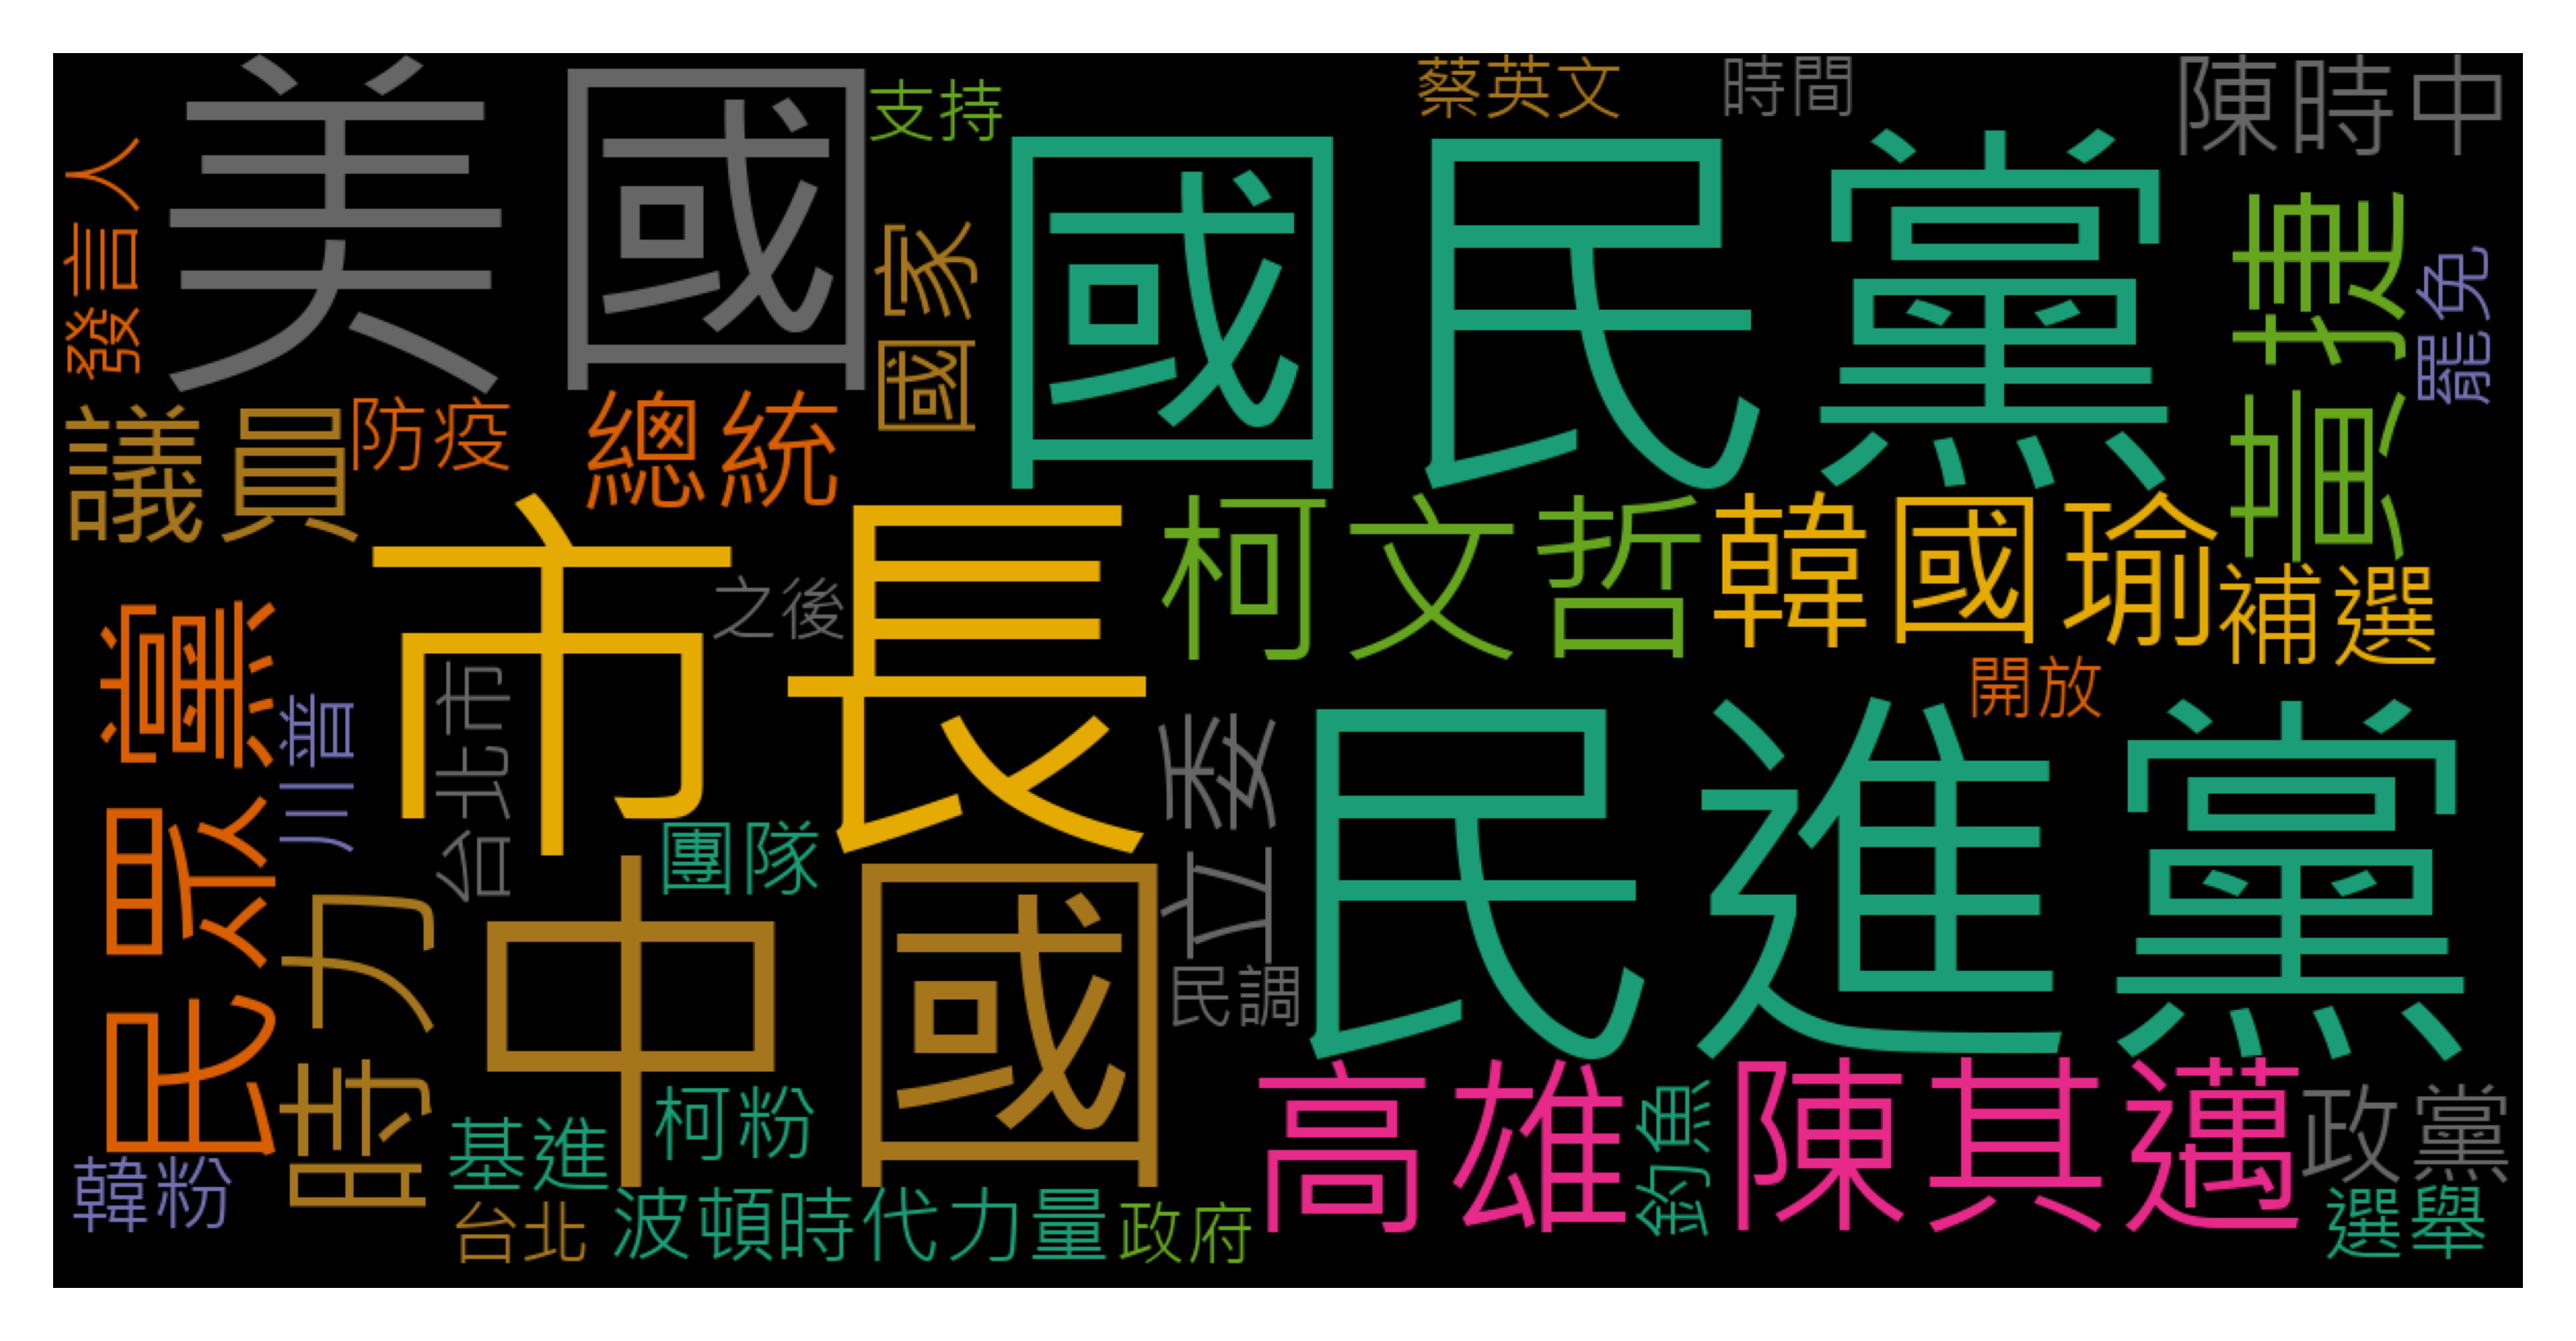

In [13]:
wordcloudPTT(content_tags) #發文的文字雲

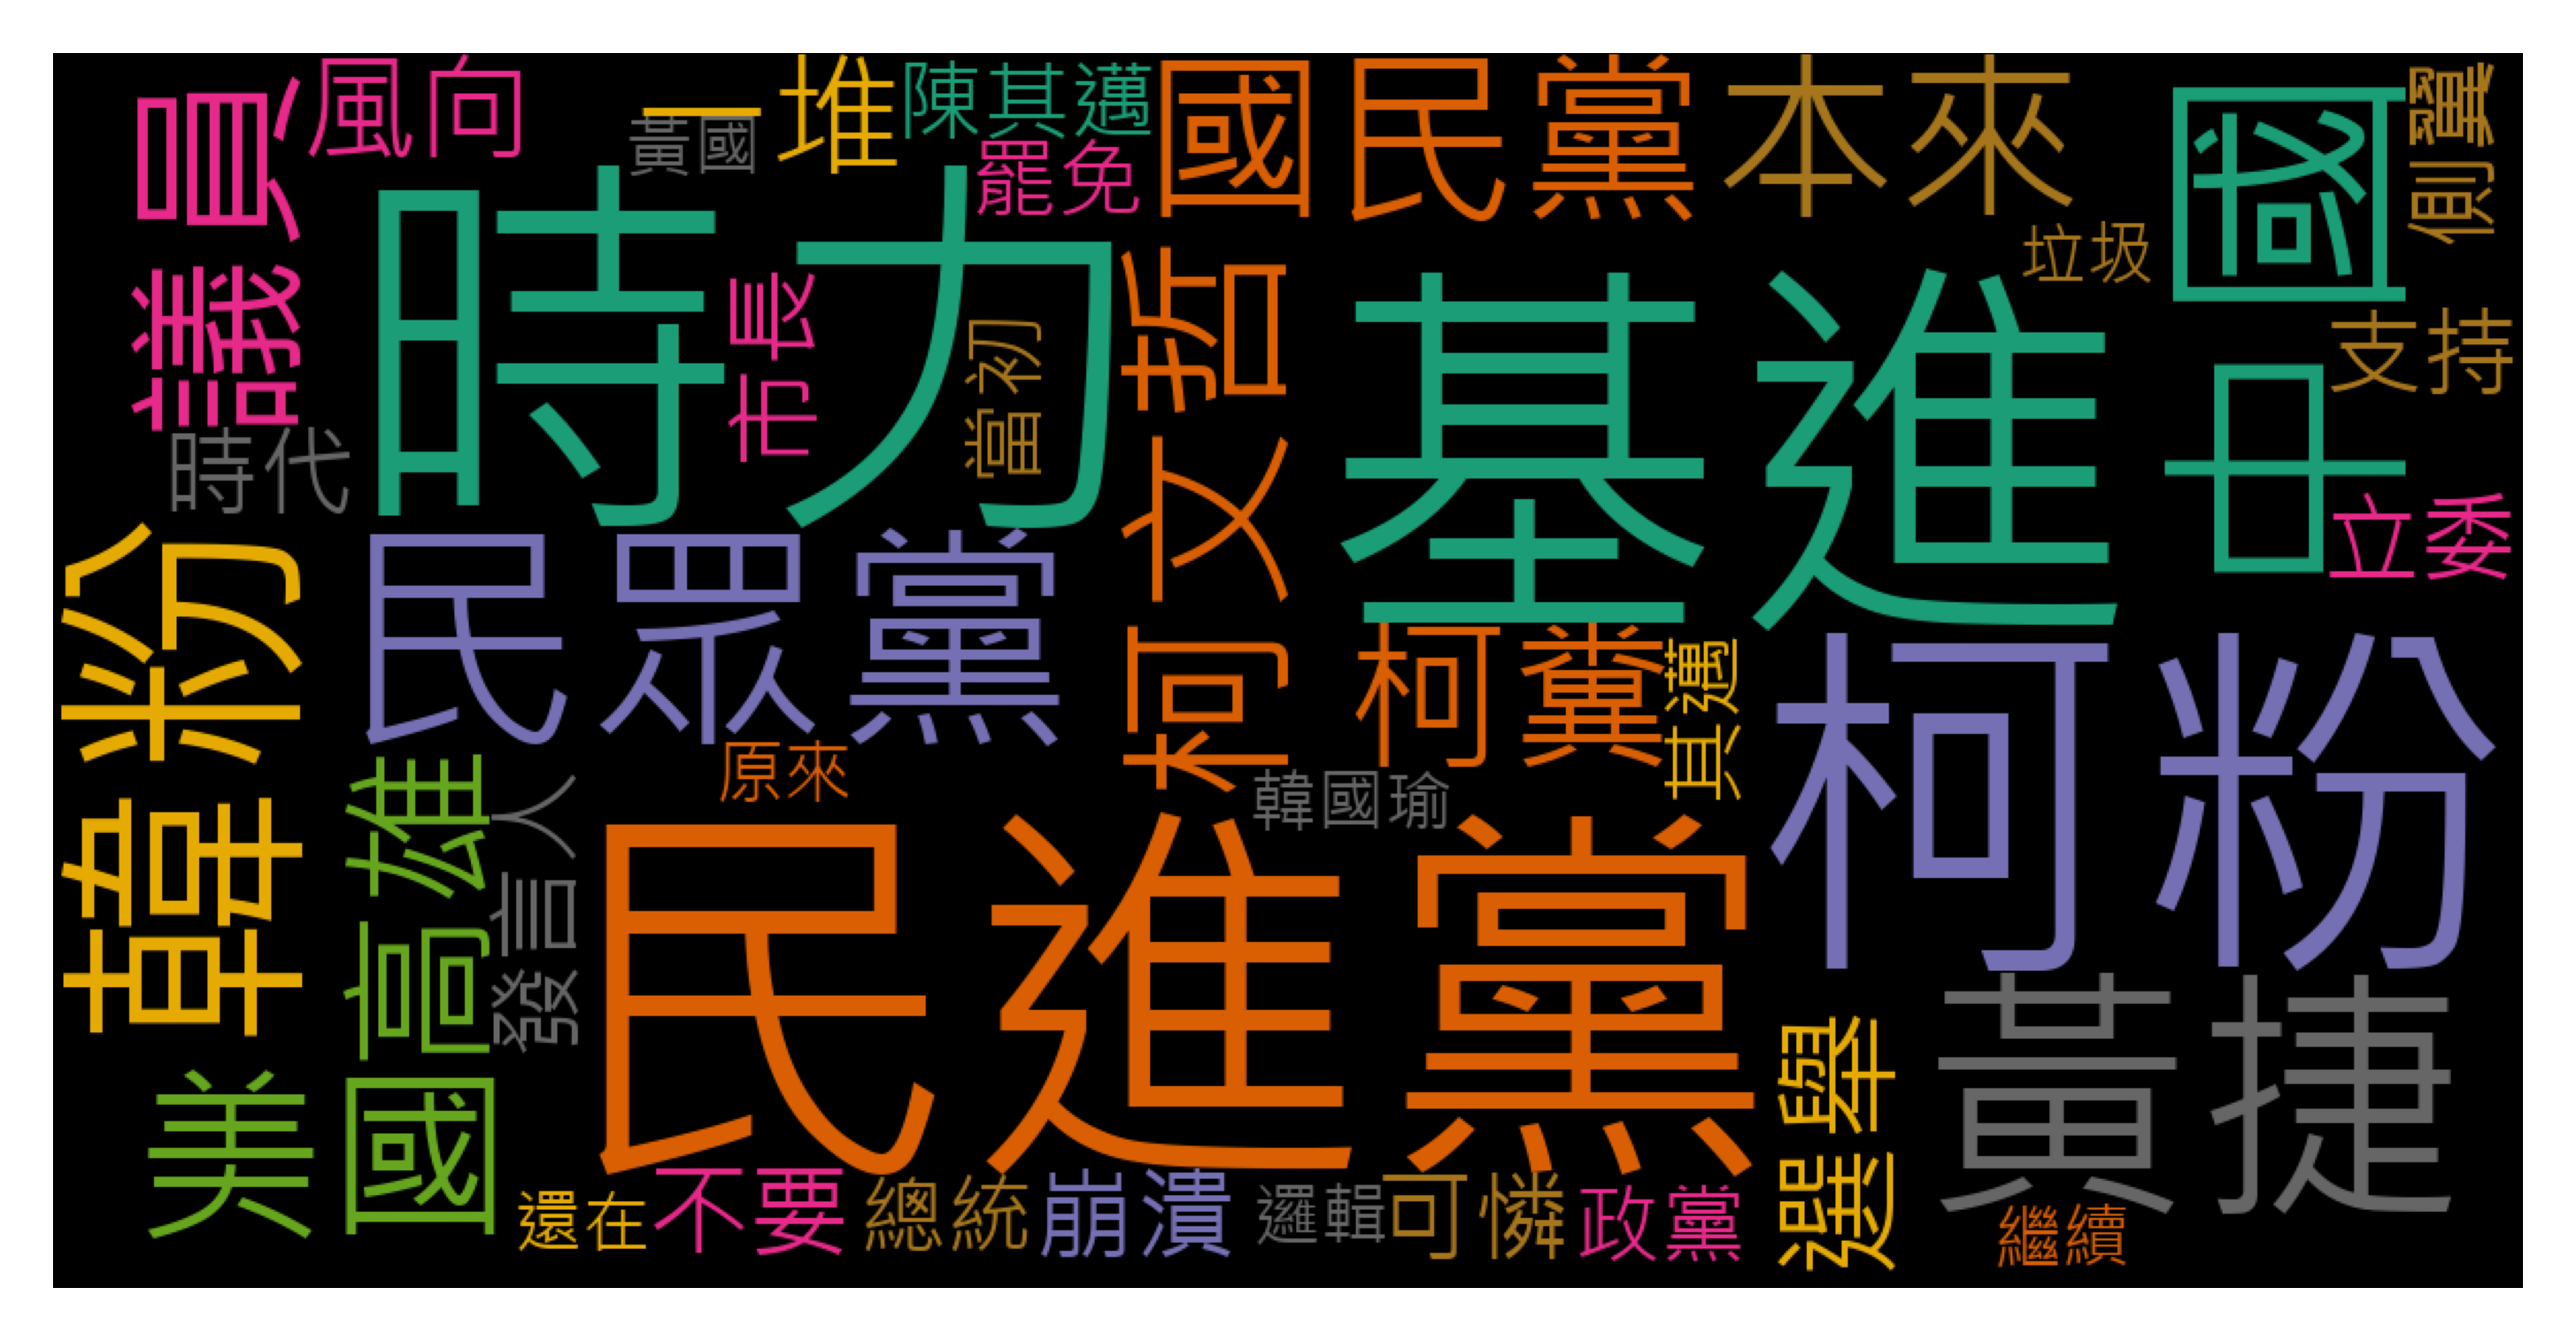

In [14]:
wordcloudPTT(message_tags) #推文的文字雲

In [15]:
content_pd.sort_values(by=['Times'], ascending = False) #發文最常出現的詞彙以及其頻率

,KeyWords,Times
0,國民黨,294
1,市長,290
7,高雄,279
2,民進黨,274
3,美國,273
4,中國,247
5,陳其邁,221
6,民眾黨,202
35,政府,195
8,黃捷,187


In [16]:
message_pd.sort_values(by=['Times'], ascending = False) #推文最常出現的詞彙以及其頻率

,KeyWords,Times
0,時力,503
1,民進黨,362
2,基進,350
3,柯粉,311
4,黃捷,299
5,韓粉,268
6,中國,263
20,不要,258
23,支持,235
7,民眾黨,221


In [17]:
pddata = pd.DataFrame(data)
pdmessage = pd.DataFrame(comments)

In [18]:
pdIdArticle = CollectUserInfo(pddata, 'article_author_id', 'article_content', 'article_times')
pdIdPush = CollectUserInfo(pdmessage, 'push_userid', 'push_content', 'push_times')

In [19]:
pdIPAuthor = CollectIPInfo(pddata, 'ip', 'article_author_id', 'author_count')
pdIPTimePush = CollectIPInfo(pdmessage, 'push_ipdatetime', 'push_userid', 'push_userid_count')
pdIPDatePush = CollectIPInfo(pdmessage, 'push_ipdate', 'push_userid', 'push_userid_count')

In [20]:
pdIdArticle

,index,article_author_id,article_content,article_times
0,17,adagiox,綠底的專業人才都被鬥走了才會這樣，\n第三勢力的精英又被排除在決策圈外，\n現在有的人才不是...,8
1,117,nicholas0406,現在 藍營側翼看到韓國瑜被罷免掉\n\n不知道是心慌還是怎樣\n\n開始學柯文哲 政治受虐兒...,7
2,33,songgood,看看白眼\n利用你們罷捷在洗聲量\n高雄沒韓市長早就沒人想看了\n記者也不想下去\n只剩罷捷...,6
3,169,aaaba,柯粉的超譯天地 https://www.facebook.com/kpFanFantasy/...,6
4,9,PunkGrass,是競選團隊發言人啊\n\n競選團隊\n\n競\n選\n團\n隊\n\n暫時的而已好嗎\n選舉...,6
...,...,...,...,...
262,162,wangsnake,現在算不算是台灣宣示主權\n是獨立主權的國家\n\n\n中共在邊境要跟印度互毆\n北京中南海...,1
263,36,rhino0314,在D卡看到的 https://tinyurl.com/y839xh7k 有政論節目的截圖\n...,1
264,164,gerund,基進千萬不要因為罷韓成功 就忘了政治處處充滿了陷阱\n\n 踏錯一步可能就和時中一樣跌落神...,1
265,35,ddaaemon,國民黨 賣台 賣給中國\n民進黨 賣釣魚台 賣給日本\n\n到底誰優誰劣 很明顯\n\n花最...,1


In [21]:
import time
time.time()

1592470018.8526917

In [22]:
start = time.time()

print(time.time()-now)

NameError: name 'now' is not defined